# Import niezbędnych bibliotek

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max.columns', None)

# Ładowanie danych
Załaduj dane z pliku 50_Startups.csv

In [87]:
df = pd.read_csv("50_Startups.csv")
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


# Dystrybucja danych

### Dokonaj analizy, wizualizacji danych i opisz wnioski dystrybucji danych dla wszystkich poniższych miar zgodnie z dołączonym przykładem poniżej:
- R&D Spend
- Administration
- Marketing Spend
- Profit

<AxesSubplot:xlabel='R&D Spend', ylabel='Density'>

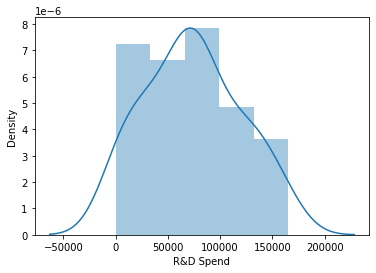

In [88]:
sns.distplot(df['R&D Spend'])

<AxesSubplot:xlabel='State', ylabel='R&D Spend'>

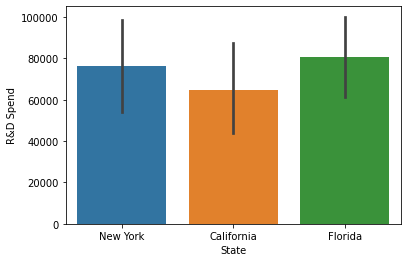

In [89]:
sns.barplot(x = 'State', y = 'R&D Spend', data = df)

<AxesSubplot:xlabel='State', ylabel='R&D Spend'>

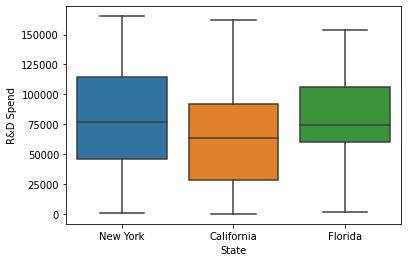

In [90]:
sns.boxplot(x = 'State', y = 'R&D Spend', data = df)

<AxesSubplot:xlabel='State', ylabel='R&D Spend'>

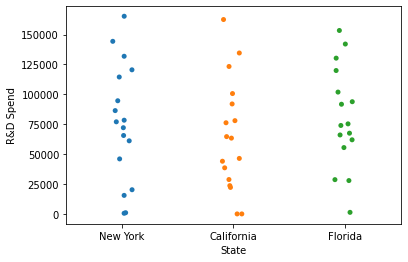

In [91]:
sns.stripplot(x ='State', y= 'R&D Spend', data = df)

# Macierz Miar:
- R&D Spend,
- Administration,
- Marketing Spend
- Profit

w ujęciu poszczególnych Stanów

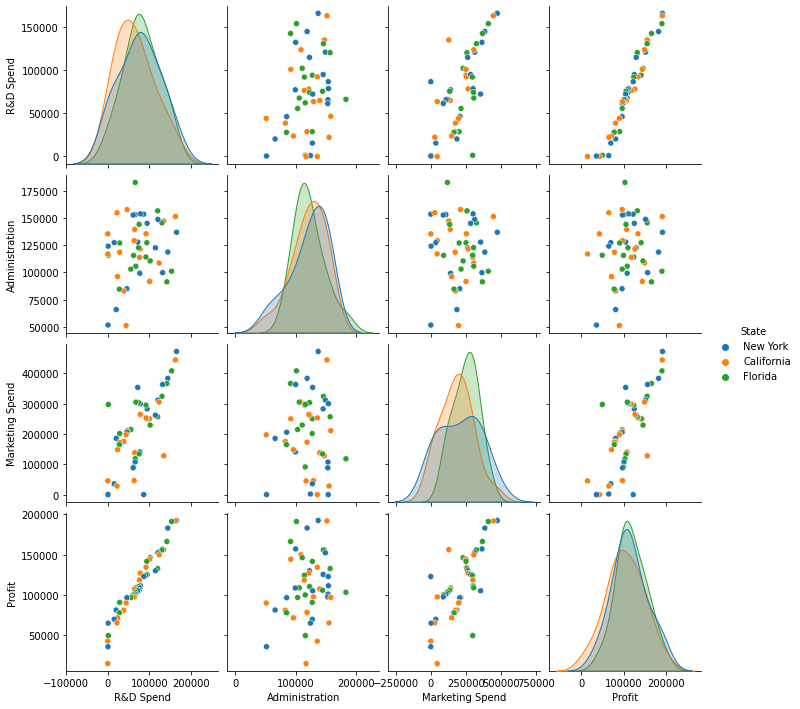

In [92]:
sns.pairplot(df, hue = 'State')

# Przygotowanie danych

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [94]:
df.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

# Normalizacja i przekszatałcenia danych

In [95]:
df.State.describe()

count           50
unique           3
top       New York
freq            17
Name: State, dtype: object

In [96]:
df = pd.get_dummies(df, columns=['State'])
df.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


## Macierz korelacji miary profit w ujęciu poszczególnych Stanów

In [97]:
df.corr()['Profit'].sort_values()

State_California   -0.145837
State_New York      0.031368
State_Florida       0.116244
Administration      0.200717
Marketing Spend     0.747766
R&D Spend           0.972900
Profit              1.000000
Name: Profit, dtype: float64

<AxesSubplot:>

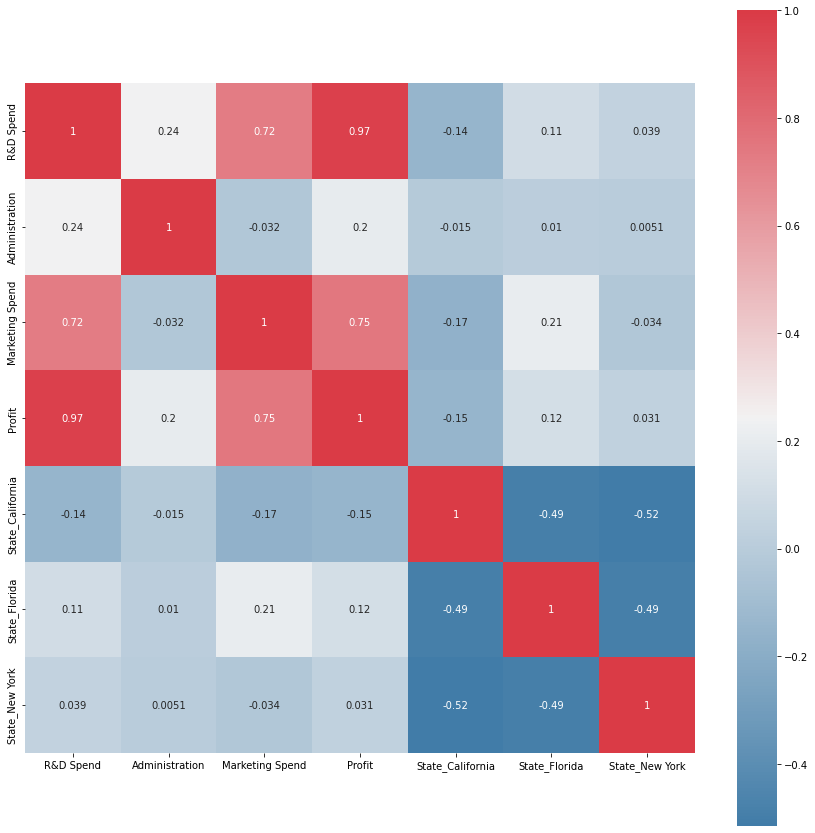

In [98]:
f, ax = plt.subplots(figsize=(15,15))
corr = df.corr()
sns.heatmap(corr, annot=True, mask=np.zeros_like(corr, dtype=np.bool),
           cmap = sns.diverging_palette(240, 10, as_cmap = True), 
           square = True, ax = ax)

## Modelowanie danych z wykorzystaniem skalowania

In [99]:
std = StandardScaler()
df_std = std.fit_transform(df)
df_std = pd.DataFrame(df_std, columns = df.columns)

In [100]:
X = df_std.drop(['Profit'], axis = 1)
y = df_std.Profit

## Przygotowanie i podział zbiorów danych

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    ,test_size = 6/8
                                                    ,random_state = 120)

In [102]:
X_train.shape

(12, 6)

## Przygotowanie i podsumowanie regressora z uwzględnieniem wszystkich zmiennych niezależnych

In [103]:
regressor = sm.OLS(y_train, X_train).fit()
print(regressor.summary())

X_train_dropped = X_train.copy()

                                 OLS Regression Results                                
Dep. Variable:                 Profit   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              60.24
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                    1.33e-05
Time:                        17:14:33   Log-Likelihood:                          8.2401
No. Observations:                  12   AIC:                                     -6.480
Df Residuals:                       7   BIC:                                     -4.056
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Ustalenie poziomu istotności statystycznej współczynników zmiennych objaśniających p-value
### Wykazanie istotnych zmiennych niezależnych mających wpływ na Profit

In [104]:
while True:
    if max(regressor.pvalues) > 0.05:
        drop_variable = regressor.pvalues[regressor.pvalues == max(regressor.pvalues)]
        print("Dropping " + drop_variable.index[0] + " and running regression again because pvalue is: " + str(drop_variable[0]))
        X_train_dropped = X_train_dropped.drop(columns = [drop_variable.index[0]])
        regressor = sm.OLS(y_train, X_train_dropped).fit()
    else:
        print("All p values less than 0.05")
        break

Dropping State_Florida and running regression again because pvalue is: 0.8509642642298432
Dropping State_New York and running regression again because pvalue is: 0.8757574682889943
Dropping State_California and running regression again because pvalue is: 0.5888729810953186
Dropping Marketing Spend and running regression again because pvalue is: 0.7183204129431893
Dropping Administration and running regression again because pvalue is: 0.07841596657802442
All p values less than 0.05


In [105]:
print(regressor.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Profit   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                              319.2
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                    1.79e-09
Time:                        17:14:33   Log-Likelihood:                          5.9420
No. Observations:                  12   AIC:                                     -9.884
Df Residuals:                      11   BIC:                                     -9.399
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Wykorzystanie SelectKBest dla wybrania najlepszych predyktorów dla zmiennej docelowej.

<AxesSubplot:>

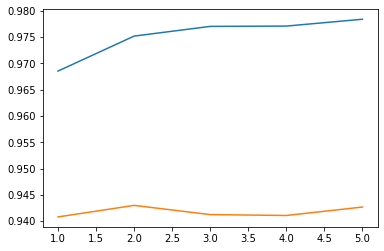

In [106]:
column_names = df.drop(columns = ['Profit']).columns
no_of_features = []
r_squared_train = []
r_squared_test = []


for k in range(1, 6):
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))
    
sns.lineplot(x = no_of_features, y = r_squared_train, legend = 'full')
sns.lineplot(x = no_of_features, y = r_squared_test, legend = 'full')

In [107]:
### Nalepszy wynik k = 1, spójrz na pomarańczową linię
selector = SelectKBest(f_regression, k = 1)
X_train_transformed = selector.fit_transform(X_train, y_train)
X_test_transformed = selector.transform(X_test)
column_names[selector.get_support()]

Index(['R&D Spend'], dtype='object')

In [108]:
def regression_model(model):
    """
    Dopasowanie modelu regresji i zwrócenie obiektu regresora oraz jego wyniku
    """
    regressor = model
    regressor.fit(X_train_transformed, y_train)
    score = regressor.score(X_test_transformed, y_test)
    return regressor, score

# Porównanie modeli predycji danych w ujęciu współczynnika determinacji R2

In [109]:
model_performance = pd.DataFrame(columns = ["Features", "Model", "Score"])

models_to_evaluate = [LinearRegression(), Ridge(), Lasso(), SVR(), RandomForestRegressor(), MLPRegressor()]

for model in models_to_evaluate:
    regressor, score = regression_model(model)
    model_performance = model_performance.append({"Features": "Linear","Model": model, "Score": round(score,2)}, ignore_index=True)

model_performance

,Features,Model,Score
0,Linear,LinearRegression(),0.94
1,Linear,Ridge(),0.93
2,Linear,Lasso(),-0.0
3,Linear,SVR(),0.69
4,Linear,"(DecisionTreeRegressor(max_features=1.0, rando...",0.83
5,Linear,MLPRegressor(),0.9
